In [1]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import h5py
import matplotlib.pyplot as plt
from scipy.optimize import leastsq,curve_fit

In [2]:
#analysis_master_path='Y:/Rb/Analysis/' # Y:\ is network drive connected to Hexagon E:\Rb\

exp_id='2018_02_09_15_22_36_Microwave and 780A Ramsey, AOM at 159 MHz'
data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
exp_path=data_master_path+exp_date+'/'+exp_id+'/'
experiment_file='results.hdf5'
dp=exp_path
cuts = [[450],[450],[450]]

q = qdp.QDP(base_data_path=dp)
q.load_data_file(experiment_file)
for r in range(5):
    q.set_thresholds(cuts, roi=r)

C:\Users\Rb\AppData\Local\Enthought\Canopy\User\lib\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Rb\AppData\Local\Enthought\Canopy\User\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [3]:
q.experiments[0]['variable_list']
xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
q.get_thresholds()
retention = q.apply_thresholds()
#np.squeeze(retention['retention'])

In [4]:
tbl_str = "ivar:\t{0:.2f}\tretention:{1:.3f} +- {2:.3f}"
for i in range(len(retention['retention'].flatten())):
    print(tbl_str.format(
        retention['ivar'].flatten()[i],
        retention['retention'].flatten()[i],
        retention['error'].flatten()[i]
    ))

ivar:	0.00	retention:0.764 +- 0.027
ivar:	0.00	retention:0.789 +- 0.027
ivar:	0.00	retention:0.750 +- 0.027
ivar:	0.00	retention:0.950 +- 0.027
ivar:	0.00	retention:0.917 +- 0.027
ivar:	0.00	retention:0.699 +- 0.031
ivar:	0.00	retention:0.739 +- 0.031
ivar:	0.00	retention:0.507 +- 0.031
ivar:	0.00	retention:0.867 +- 0.031
ivar:	0.00	retention:0.778 +- 0.031
ivar:	0.00	retention:0.707 +- 0.033
ivar:	0.00	retention:0.704 +- 0.033
ivar:	0.00	retention:0.173 +- 0.033
ivar:	0.00	retention:0.947 +- 0.033
ivar:	0.00	retention:0.889 +- 0.033
ivar:	0.00	retention:0.667 +- 0.036
ivar:	0.00	retention:0.606 +- 0.036
ivar:	0.00	retention:0.200 +- 0.036
ivar:	0.00	retention:0.821 +- 0.036
ivar:	0.00	retention:0.941 +- 0.036
ivar:	0.00	retention:0.635 +- 0.037
ivar:	0.00	retention:0.592 +- 0.037
ivar:	0.00	retention:0.480 +- 0.037
ivar:	0.00	retention:0.909 +- 0.037
ivar:	0.00	retention:0.700 +- 0.037
ivar:	0.00	retention:0.718 +- 0.038
ivar:	0.00	retention:0.557 +- 0.038
ivar:	0.00	retention:0.733 +

In [5]:
def sin(t,amp,freq,phase,offset):
    res = (amp*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def decaying_sin(t,tau,amp,freq,phase,offset):
    res = (amp*np.exp(-t/tau)*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def est_freq(ydata,tgap,tau,amp,freq,phase,offset): # Estimation of frequency change (from dy/df where y=sinusoidal fit)
    res=(ydata-decaying_sin(tau,tgap,amp,freq,phase,offset))/(amp*np.exp(-tgap/tau)*2*np.pi*tgap*np.cos(2*np.pi*freq*tgap+phase))
    return res

def gaussian(x,amp,x0,sigma,offset):
    res=(amp*np.exp((-(x-x0)**2)/(sigma**2)))+offset
    return res

<IPython.core.display.Javascript object>


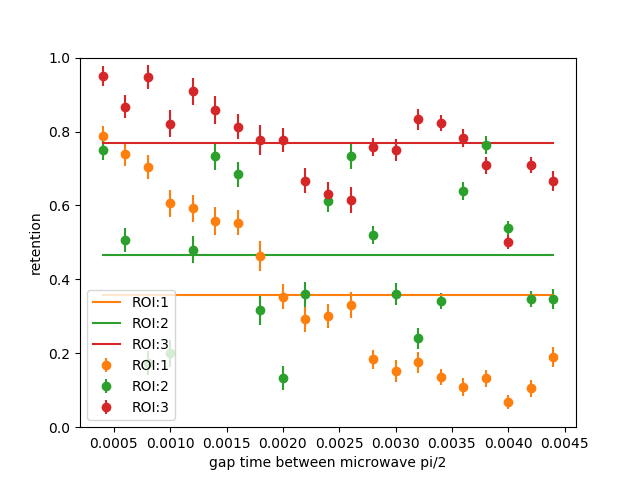

ROI:1, amplitude : 0.5, location: 156.0 , sigma:2.0, offset:0.358756228284
ROI:2, amplitude : 0.5, location: 160.0 , sigma:2.0, offset:0.465781119466
ROI:3, amplitude : 0.5, location: 164.0 , sigma:2.0, offset:0.769816798102


C:\Users\Rb\AppData\Local\Enthought\Canopy\User\lib\site-packages\scipy\optimize\minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [6]:
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = plt.subplots()
fit_guesses=[0.5,160,2,0]
roi_dependency=[0,4,0,0]
fitted_parameters=[]
for roi in [1,2,3]:
    
    data = []
    reten = []
    err = []
    for e in range(len(np.squeeze(retention['ivar']))):
        data.append(np.squeeze(retention['ivar'])[e][roi])
        reten.append(np.squeeze(retention['retention'])[e][roi])
        err.append(np.squeeze(retention['error'])[e][roi])
    ax.errorbar(data,reten,yerr=err,label="ROI:{}".format(roi),fmt='o',color=colors[roi])
    guesses=np.add(fit_guesses,np.ones(len(fit_guesses))*(roi-2)*roi_dependency)
    fit = curve_fit(gaussian,data,reten,guesses)
    print "ROI:{}, amplitude : {}, location: {} , sigma:{}, offset:{}".format(roi,fit[0][0],fit[0][1],fit[0][2],fit[0][3])
    fitted_parameters.append(fit[0])
    #print fit[0]
    xarray=np.linspace(np.min(data),np.max(data),100)
    yfit=gaussian(xarray, np.float(fit[0][0]),np.float(fit[0][1]),np.float(fit[0][2]),np.float(fit[0][3]))
    plt.plot(xarray,yfit,label="ROI:{}".format(roi),color=colors[roi])

plt.show()
ax.set_ylim(0, 1)
ax.set_xlabel(xlab)
ax.set_ylabel('retention')
ax.legend()

In [9]:
print np.mean([154.919574624,159.658498404])

157.289036514


In [20]:
np.squeeze(retention['error'][0][0])

array([ 0.00385526,  0.00385526,  0.00385526,  0.00385526,  0.00385526])

In [37]:
np.squeeze(retention['error'])[2][2]

0.026591154480290473

In [4]:
cameradata=q.get_beampositions()

In [7]:
cameradata

{'FORTX': array([[ 0.0004,  0.0006,  0.0008,  0.001 ,  0.0012,  0.0014,  0.0016,
          0.0018,  0.002 ,  0.0022,  0.0024,  0.0026,  0.0028,  0.003 ,
          0.0032,  0.0034,  0.0036,  0.0038,  0.004 ,  0.0042,  0.0044]]),
 'FORTY': array([[ 0.0004,  0.0006,  0.0008,  0.001 ,  0.0012,  0.0014,  0.0016,
          0.0018,  0.002 ,  0.0022,  0.0024,  0.0026,  0.0028,  0.003 ,
          0.0032,  0.0034,  0.0036,  0.0038,  0.004 ,  0.0042,  0.0044]]),
 'RedX': array([[ 0.0004,  0.0006,  0.0008,  0.001 ,  0.0012,  0.0014,  0.0016,
          0.0018,  0.002 ,  0.0022,  0.0024,  0.0026,  0.0028,  0.003 ,
          0.0032,  0.0034,  0.0036,  0.0038,  0.004 ,  0.0042,  0.0044]]),
 'RedY': array([[ 0.0004,  0.0006,  0.0008,  0.001 ,  0.0012,  0.0014,  0.0016,
          0.0018,  0.002 ,  0.0022,  0.0024,  0.0026,  0.0028,  0.003 ,
          0.0032,  0.0034,  0.0036,  0.0038,  0.004 ,  0.0042,  0.0044]]),
 'ivar': array([[ 0.0004,  0.0006,  0.0008,  0.001 ,  0.0012,  0.0014,  0.0016,
          

In [39]:
q.experiments[0]['iterations']

{0: {'FORT_camera_dataX': 618.55816727844319,
  'FORT_camera_dataY': 747.13755473674496,
  'Red_camera_dataX': 448.33913527919964,
  'Red_camera_dataY': 542.50006453458684,
  'signal_data': array([[[[2210,  722,  920,  -69,   -4]],
  
          [[ -16,  982,  957,  135,   16]],
  
          [[   6,  -23,  -14,   -6,  -26]]],
  
  
         [[[ 203,   46, -108,  -97,  -49]],
  
          [[  52,  -41,  -76,  -34,  146]],
  
          [[  -7,  -29,    0,  -35,   29]]],
  
  
         [[[  52,  842, 1424,   77, 1118]],
  
          [[  20, 1372, 1046,  158, 1103]],
  
          [[  99,  -35,   40,  101,  -20]]],
  
  
         ..., 
         [[[ -63,  906,  -11,  698,   11]],
  
          [[  16, -173, -132, 1106,    6]],
  
          [[ -54,  -54,   18,   51,   -3]]],
  
  
         [[[  17,  -23,  -96,   -6,  783]],
  
          [[  52,  -44,   -8,   48,  881]],
  
          [[  41,  -33,  -36,    1,  -14]]],
  
  
         [[[ 924, 2052,   83, -104,  -45]],
  
          [[ -85,  894, -

In [25]:
exps=q.load_hdf5_file(dp+experiment_file)

In [37]:
exps[0]['iterations'][0]

{'FORT_camera_dataX': 618.55816727844319,
 'FORT_camera_dataY': 747.13755473674496,
 'Red_camera_dataX': 448.33913527919964,
 'Red_camera_dataY': 542.50006453458684,
 'signal_data': array([[[[2210,  722,  920,  -69,   -4]],
 
         [[ -16,  982,  957,  135,   16]],
 
         [[   6,  -23,  -14,   -6,  -26]]],
 
 
        [[[ 203,   46, -108,  -97,  -49]],
 
         [[  52,  -41,  -76,  -34,  146]],
 
         [[  -7,  -29,    0,  -35,   29]]],
 
 
        [[[  52,  842, 1424,   77, 1118]],
 
         [[  20, 1372, 1046,  158, 1103]],
 
         [[  99,  -35,   40,  101,  -20]]],
 
 
        ..., 
        [[[ -63,  906,  -11,  698,   11]],
 
         [[  16, -173, -132, 1106,    6]],
 
         [[ -54,  -54,   18,   51,   -3]]],
 
 
        [[[  17,  -23,  -96,   -6,  783]],
 
         [[  52,  -44,   -8,   48,  881]],
 
         [[  41,  -33,  -36,    1,  -14]]],
 
 
        [[[ 924, 2052,   83, -104,  -45]],
 
         [[ -85,  894, -115,  -76,  -71]],
 
         [[   2,  -55,  -

In [38]:
q

<QDP.qdp.QDP instance at 0x000000000CDEBB48>